# 📘 Notebook 1: Data Integrity & Feature Engineering

## Purpose
Generate candidate features with potential information content, **without any modeling or trading logic**.

## Allowed
- ✅ Feature construction
- ✅ Statistical inspection
- ✅ Stationarity tests
- ✅ Correlation analysis
- ✅ Cross-sectional & time-series diagnostics

## Forbidden
- ❌ ML models
- ❌ Targets (forward returns)
- ❌ Backtests
- ❌ Sharpe ratios
- ❌ Portfolio logic

## Required Outputs
1. `features_is.parquet` - Feature panel for in-sample period
2. Feature metadata (names, definitions, units)
3. Diagnostics: stationarity, distribution, correlation, stability

## Required Tests
- Lookahead bias checks
- Feature leakage tests
- Redundancy checks

**If features fail diagnostics, they do not progress to Notebook 2.**

---

In [15]:
# =============================================================================
# CELL 1: IMPORTS & CONFIGURATION
# =============================================================================
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 1. ROBUST PATH FINDING
def find_project_root(target_name="quant_pipeline"):
    """Search upwards from current directory to find the project root."""
    current_path = Path.cwd().resolve()
    for parent in [current_path] + list(current_path.parents):
        if (parent / target_name).exists():
            return parent
    return current_path # Fallback to CWD if not found

PROJECT_ROOT = find_project_root("quant_pipeline")

# 2. UPDATE SYS.PATH
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 3. IMPORT CUSTOM MODULES
try:
    from quant_pipeline import set_global_seed
    from quant_pipeline.data import DataConfig, DataLoader, DataSplitter, compute_data_quality_report
    from quant_pipeline.features import FeaturePanelBuilder, compute_feature_correlation_matrix, identify_redundant_features
    from quant_pipeline.diagnostics import diagnose_data_quality, diagnose_features, DiagnosticSuite
    print("✅ Custom modules imported successfully.")
except ImportError as e:
    print(f"❌ Import Error: {e}")
    print(f"Current sys.path looking at: {PROJECT_ROOT}")

# 4. CONFIGURATION
warnings.filterwarnings('ignore')
RANDOM_SEED = 42
set_global_seed(RANDOM_SEED)

# Define and create output directory
OUTPUT_DIR = PROJECT_ROOT / "data" / "processed"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("="*70)
print("📘 NOTEBOOK 1: DATA INTEGRITY & FEATURE ENGINEERING")
print("="*70)
print(f"Project root: {PROJECT_ROOT}")
print(f"Output dir:   {OUTPUT_DIR}")
print(f"Random seed:  {RANDOM_SEED}")

✅ Custom modules imported successfully.
[SEED] Global random seed set to 42
📘 NOTEBOOK 1: DATA INTEGRITY & FEATURE ENGINEERING
Project root: C:\Users\ponna\OneDrive\Desktop\Precog Task
Output dir:   C:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed
Random seed:  42


---
## Stage 1: Load and Validate Raw Data

In [16]:
# =============================================================================
# CELL 2: LOAD DATA
# =============================================================================

# Configuration
config = DataConfig(
    data_dir=PROJECT_ROOT / "data" / "raw" / "assets",
    oos_start="2024-01-01",
    min_history_days=252,
    random_seed=RANDOM_SEED
)

print(f"\nConfiguration: {config}")

# Load data
loader = DataLoader(config)
loader.load()

# Get data
prices = loader.get_prices()
returns = loader.get_returns()

print(f"\n📊 Data loaded successfully")


Configuration: DataConfig(oos_start=2024-01-01, seed=42)
[DATA] Loading 100 assets...
[DATA] Loaded: 2511 days, 100 assets
[DATA] Date range: 2016-01-25 to 2026-01-16
[DATA] Hash: c556925bf49ee481...

📊 Data loaded successfully


In [17]:
# =============================================================================
# CELL 3: DATA QUALITY DIAGNOSTICS
# =============================================================================

# Run data quality diagnostics
data_diag = diagnose_data_quality(prices, returns)
data_diag.print_summary()

# Quality report
quality_report = compute_data_quality_report(prices, returns)
print("\n📊 Data Quality Report:")
for k, v in quality_report.items():
    print(f"   {k}: {v}")

# CHECKPOINT: If data diagnostics fail, STOP here
if not data_diag.passed():
    raise RuntimeError("❌ DATA DIAGNOSTICS FAILED - Cannot proceed to feature engineering")


DIAGNOSTIC SUITE: Data Quality
✅ Missing Values: Missing values acceptable: 0.00%
✅ Extreme Returns: Extreme returns acceptable: 0.0008%
✅ Zero Returns: Zero returns acceptable: 0.37%
✅ Data Sorted: Data is sorted by date

Summary: 4 passed, 0 warnings, 0 failed
Overall: PASS

📊 Data Quality Report:
   n_assets: 100
   n_days: 2511
   date_range: 2016-01-25 to 2026-01-16
   missing_pct: 0.0
   zero_return_pct: 0.3735563520509757
   extreme_return_pct: 0.015929908403026685
   mean_daily_return: 0.07991152122217934
   mean_daily_vol: 1.8270689442794747


In [18]:
# =============================================================================
# CELL 4: SPLIT DATA (IS/OOS)
# =============================================================================

# Split data - OOS is NEVER used in this notebook
splitter = DataSplitter(loader)
prices_is, prices_oos, returns_is, returns_oos = splitter.split()

# We only work with IS in this notebook
# OOS is stored but NEVER touched
log_prices_is = np.log(prices_is)

print("\n⚠️ NOTE: OOS data is loaded but will NOT be used in this notebook")
print("   All feature engineering uses IS data only")

[SPLIT] IS: 2016-01-25 to 2023-12-29 (1998 days)
[SPLIT] OOS: 2024-01-02 to 2026-01-16 (513 days)
[SPLIT] Ratio: 79.6% IS / 20.4% OOS

⚠️ NOTE: OOS data is loaded but will NOT be used in this notebook
   All feature engineering uses IS data only


---
## Stage 2: Feature Engineering (IS Only)

In [32]:
# =============================================================================
# CELL 5: BUILD FEATURE PANEL
# =============================================================================

print("="*70)
print("🔧 FEATURE ENGINEERING")
print("="*70)

# Build features using our module (no code duplication)
builder = FeaturePanelBuilder()
panel_is = builder.build(prices_is, returns_is, log_prices_is)

# Get feature names
feature_names = builder.get_feature_names()
print(f"\n📊 Features generated: {len(feature_names)}")

# Show feature metadata
metadata = builder.get_metadata()
print("\n📋 Feature Metadata:")
display(metadata)

🔧 FEATURE ENGINEERING
   Processing 20/100 assets...
   Processing 40/100 assets...
   Processing 60/100 assets...
   Processing 80/100 assets...
   Processing 100/100 assets...
[FEATURES] Built panel: 199,800 rows, 41 features

📊 Features generated: 41

📋 Feature Metadata:


,name,family,lookback,description,unit,stationary
0,mom_5d,momentum,5,5-day cumulative return,return,None
1,mom_10d,momentum,10,10-day cumulative return,return,None
2,mom_21d,momentum,21,21-day cumulative return,return,None
3,mom_63d,momentum,63,63-day cumulative return,return,None
4,mom_acceleration,momentum,21,Momentum acceleration (5d - 21d),dimensionless,None
5,mom_reversal,momentum,5,Mean reversion signal (negative 5d mom),dimensionless,None
6,mom_zscore,momentum,63,Z-scored 21d momentum,dimensionless,None
7,mom_consistency,momentum,21,Fraction of positive returns over 21d,dimensionless,None
8,vol_5d,volatility,5,5-day rolling volatility,volatility,None
9,vol_10d,volatility,10,10-day rolling volatility,volatility,None


---
## Stage 2.1: Kalman Filter Visualization (Zoomed)

📈 KALMAN FILTER SMOOTHING VISUALIZATION


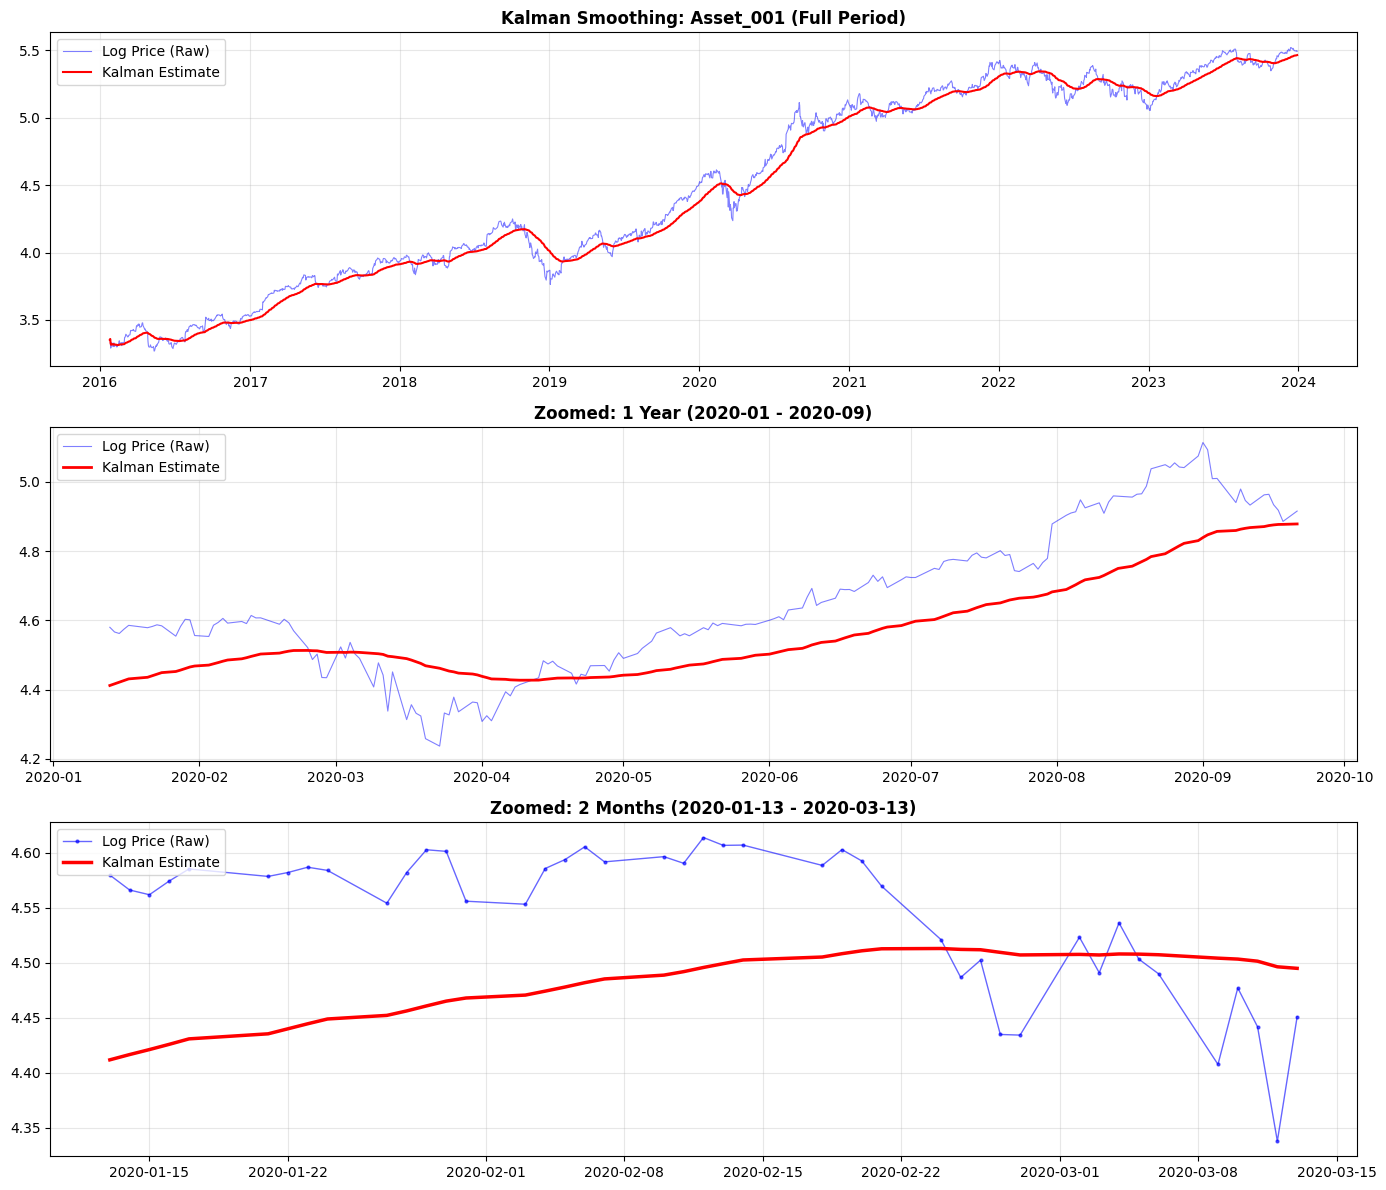


📊 Kalman Smoothing Statistics for Asset_001:
   Raw log price std: 0.018426
   Kalman estimate std: 0.002265
   Noise reduction: 87.7%
   Mean absolute deviation: 0.059701


In [33]:
# =============================================================================
# CELL: KALMAN FILTER VISUALIZATION (ZOOMED)
# =============================================================================

print("="*70)
print("📈 KALMAN FILTER SMOOTHING VISUALIZATION")
print("="*70)

# Select a sample asset
sample_ticker = prices_is.columns[0]
sample_data = panel_is[panel_is['ticker'] == sample_ticker].copy()
sample_data = sample_data.set_index('date').sort_index()

# Check if Kalman visualization columns exist
if '_kalman_est' not in panel_is.columns or '_log_price' not in panel_is.columns:
    print("⚠️ Kalman visualization columns not found in panel.")
    print("   Recomputing Kalman estimate directly...")
    
    # Compute Kalman estimate directly
    from quant_pipeline.features import kalman_filter_1d
    log_price = np.log(prices_is[sample_ticker])
    kalman_est = pd.Series(kalman_filter_1d(log_price.values), index=log_price.index)
else:
    kalman_est = sample_data['_kalman_est']
    log_price = sample_data['_log_price']

# Create figure with multiple zooms
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Full time series
ax1 = axes[0]
ax1.plot(log_price.index, log_price.values, 'b-', alpha=0.5, linewidth=0.8, label='Log Price (Raw)')
ax1.plot(kalman_est.index, kalman_est.values, 'r-', linewidth=1.5, label='Kalman Estimate')
ax1.set_title(f'Kalman Smoothing: {sample_ticker} (Full Period)', fontweight='bold', fontsize=12)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Zoomed: 1 year
zoom_start = log_price.index[len(log_price)//2]
zoom_end = zoom_start + pd.Timedelta(days=252)
ax2 = axes[1]
mask = (log_price.index >= zoom_start) & (log_price.index <= zoom_end)
ax2.plot(log_price.index[mask], log_price.values[mask], 'b-', alpha=0.5, linewidth=0.8, label='Log Price (Raw)')
ax2.plot(kalman_est.index[mask], kalman_est.values[mask], 'r-', linewidth=2, label='Kalman Estimate')
ax2.set_title(f'Zoomed: 1 Year ({zoom_start.strftime("%Y-%m")} - {zoom_end.strftime("%Y-%m")})', fontweight='bold', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Zoomed: 2 months
zoom_start2 = log_price.index[len(log_price)//2]
zoom_end2 = zoom_start2 + pd.Timedelta(days=60)
ax3 = axes[2]
mask2 = (log_price.index >= zoom_start2) & (log_price.index <= zoom_end2)
ax3.plot(log_price.index[mask2], log_price.values[mask2], 'b-', alpha=0.6, linewidth=1, marker='o', markersize=2, label='Log Price (Raw)')
ax3.plot(kalman_est.index[mask2], kalman_est.values[mask2], 'r-', linewidth=2.5, label='Kalman Estimate')
ax3.set_title(f'Zoomed: 2 Months ({zoom_start2.strftime("%Y-%m-%d")} - {zoom_end2.strftime("%Y-%m-%d")})', fontweight='bold', fontsize=12)
ax3.legend(loc='upper left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'kalman_smoothing_zoomed.png', dpi=150, bbox_inches='tight')
plt.show()

# Print smoothing statistics
noise = log_price - kalman_est
print(f"\n📊 Kalman Smoothing Statistics for {sample_ticker}:")
print(f"   Raw log price std: {log_price.diff().std():.6f}")
print(f"   Kalman estimate std: {kalman_est.diff().std():.6f}")
print(f"   Noise reduction: {(1 - kalman_est.diff().std()/log_price.diff().std())*100:.1f}%")
print(f"   Mean absolute deviation: {noise.abs().mean():.6f}")

---
## Stage 2.2: Regime Features Analysis

🎯 VOLATILITY REGIME FEATURES

📊 Regime Features (15):
   - vol_regime
   - regime_state
   - regime_confidence
   - regime_entropy
   - regime_p_high_vol
   - regime_delta_prob
   - regime_duration
   - regime_transition_rate
   - kalman_regime_conf
   - kalman_regime_entropy
   - mom_x_regime_conf
   - reversal_x_regime_shock
   - kalman_x_regime_lowvol
   - mom_x_regime_duration
   - vol_x_regime_entropy

📊 HMM Features (0):


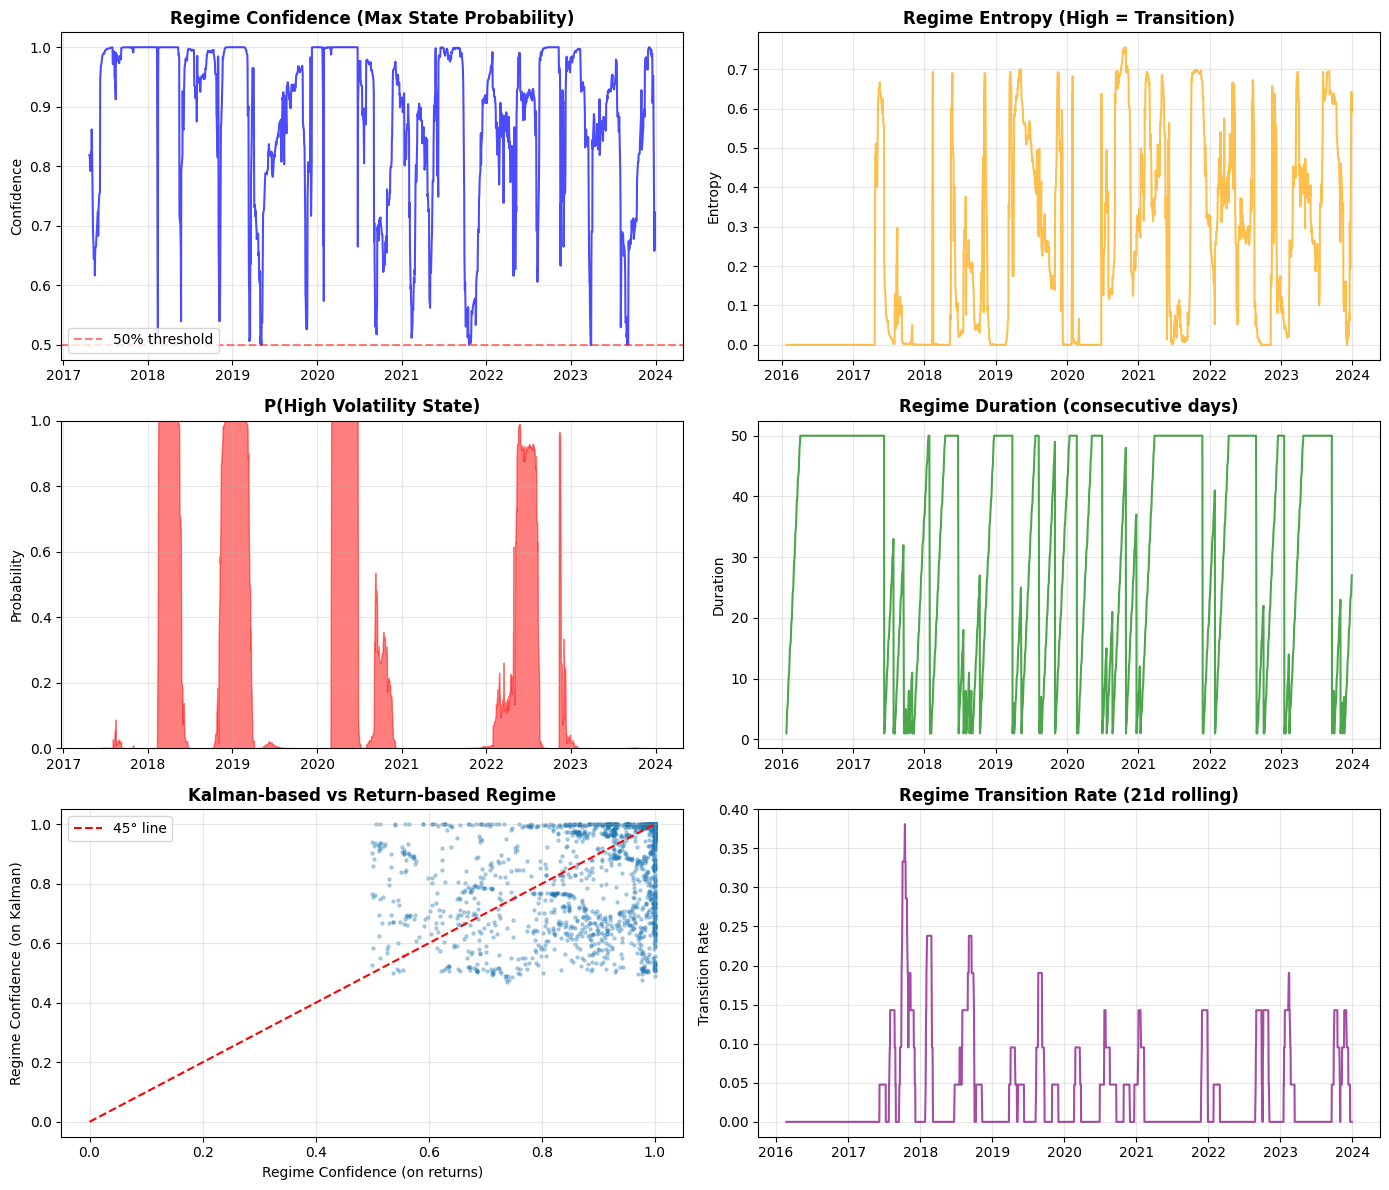


📊 Regime Feature Statistics for Asset_001:
   Mean confidence: 0.888
   Mean entropy: 0.225
   Mean P(high vol): 0.201
   Mean duration: 69.3 days
   Mean transition rate: 0.034


In [34]:
# =============================================================================
# CELL: REGIME FEATURES VISUALIZATION
# =============================================================================

print("="*70)
print("🎯 VOLATILITY REGIME FEATURES")
print("="*70)

# Check which regime features are available
regime_features = [c for c in panel_is.columns if 'regime' in c.lower()]
hmm_features = [c for c in panel_is.columns if c.startswith('hmm_')]

print(f"\n📊 Regime Features ({len(regime_features)}):")
for f in regime_features:
    print(f"   - {f}")

print(f"\n📊 HMM Features ({len(hmm_features)}):")
for f in hmm_features:
    print(f"   - {f}")

# Use regime features (fast version) for visualization
if 'regime_confidence' in panel_is.columns:
    # Re-extract sample data with regime features
    sample_data = panel_is[panel_is['ticker'] == sample_ticker].copy()
    sample_data = sample_data.set_index('date').sort_index()
    
    # Visualize regime features
    fig, axes = plt.subplots(3, 2, figsize=(14, 12))
    
    # Regime Confidence over time
    ax1 = axes[0, 0]
    ax1.plot(sample_data.index, sample_data['regime_confidence'], 'b-', alpha=0.7)
    ax1.set_title('Regime Confidence (Max State Probability)', fontweight='bold')
    ax1.set_ylabel('Confidence')
    ax1.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Regime Entropy over time
    ax2 = axes[0, 1]
    ax2.plot(sample_data.index, sample_data['regime_entropy'], 'orange', alpha=0.7)
    ax2.set_title('Regime Entropy (High = Transition)', fontweight='bold')
    ax2.set_ylabel('Entropy')
    ax2.grid(True, alpha=0.3)
    
    # P(High Vol)
    ax3 = axes[1, 0]
    ax3.fill_between(sample_data.index, 0, sample_data['regime_p_high_vol'], alpha=0.5, color='red')
    ax3.set_title('P(High Volatility State)', fontweight='bold')
    ax3.set_ylabel('Probability')
    ax3.set_ylim(0, 1)
    ax3.grid(True, alpha=0.3)
    
    # Regime Duration
    ax4 = axes[1, 1]
    ax4.plot(sample_data.index, sample_data['regime_duration'].clip(upper=50), 'green', alpha=0.7)
    ax4.set_title('Regime Duration (consecutive days)', fontweight='bold')
    ax4.set_ylabel('Duration')
    ax4.grid(True, alpha=0.3)
    
    # Return-based vs Kalman-based regime confidence
    ax5 = axes[2, 0]
    ax5.scatter(sample_data['regime_confidence'], sample_data['kalman_regime_conf'], alpha=0.3, s=5)
    ax5.plot([0, 1], [0, 1], 'r--', label='45° line')
    ax5.set_xlabel('Regime Confidence (on returns)')
    ax5.set_ylabel('Regime Confidence (on Kalman)')
    ax5.set_title('Kalman-based vs Return-based Regime', fontweight='bold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Transition rate
    ax6 = axes[2, 1]
    ax6.plot(sample_data.index, sample_data['regime_transition_rate'], 'purple', alpha=0.7)
    ax6.set_title('Regime Transition Rate (21d rolling)', fontweight='bold')
    ax6.set_ylabel('Transition Rate')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'regime_features.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Statistics
    print(f"\n📊 Regime Feature Statistics for {sample_ticker}:")
    print(f"   Mean confidence: {sample_data['regime_confidence'].mean():.3f}")
    print(f"   Mean entropy: {sample_data['regime_entropy'].mean():.3f}")
    print(f"   Mean P(high vol): {sample_data['regime_p_high_vol'].mean():.3f}")
    print(f"   Mean duration: {sample_data['regime_duration'].mean():.1f} days")
    print(f"   Mean transition rate: {sample_data['regime_transition_rate'].mean():.3f}")
else:
    print("⚠️ Regime features not found - rebuild feature panel")

In [35]:
# =============================================================================
# CELL 6: FEATURE DISTRIBUTION ANALYSIS
# =============================================================================

print("="*70)
print("📊 FEATURE DISTRIBUTION ANALYSIS")
print("="*70)

# Summary statistics
feature_stats = panel_is[feature_names].describe().T
feature_stats['missing_pct'] = panel_is[feature_names].isna().mean() * 100
feature_stats['skew'] = panel_is[feature_names].skew()
feature_stats['kurtosis'] = panel_is[feature_names].kurtosis()

print("\n📊 Feature Statistics:")
display(feature_stats[['mean', 'std', 'min', 'max', 'missing_pct', 'skew', 'kurtosis']].round(4))

📊 FEATURE DISTRIBUTION ANALYSIS

📊 Feature Statistics:


,mean,std,min,max,missing_pct,skew,kurtosis
mom_5d,0.0040,0.0409,-0.5494,0.6736,0.2503,-0.0170,10.1632
mom_10d,0.0080,0.0568,-0.9133,0.6624,0.5005,-0.2743,8.1315
mom_21d,0.0168,0.0813,-1.1476,0.7918,1.0511,-0.2892,6.9388
mom_63d,0.0479,0.1310,-1.1194,1.1246,3.1532,0.1271,4.2986
mom_acceleration,-0.0128,0.0713,-0.6750,1.0261,1.0511,0.2273,7.1860
mom_reversal,-0.0040,0.0409,-0.6736,0.5494,0.2503,0.0170,10.1632
mom_zscore,-0.0350,1.2056,-5.7346,7.6514,4.1542,-0.0632,-0.1372
mom_consistency,0.5271,0.1055,0.0952,0.9048,1.0511,-0.0257,-0.1082
vol_5d,0.0151,0.0119,0.0002,0.2743,0.2503,3.5853,27.4949
vol_10d,0.0158,0.0108,0.0012,0.1934,0.5005,3.3528,21.8513


In [36]:
# =============================================================================
# CELL 7: FEATURE DIAGNOSTICS
# =============================================================================

print("="*70)
print("🔍 FEATURE DIAGNOSTICS")
print("="*70)

# Run diagnostics
feature_diag = diagnose_features(panel_is, feature_names, n_periods=4)
feature_diag.print_summary()

# CHECKPOINT: If features fail, investigate but don't necessarily stop
if not feature_diag.passed():
    print("\n⚠️ WARNING: Some features failed diagnostics")
    print("   Review the failures above before proceeding")

🔍 FEATURE DIAGNOSTICS

DIAGNOSTIC SUITE: Feature Quality
⚠️ Missing: regime_confidence: Some missing: 15.7%
⚠️ Missing: regime_p_high_vol: Some missing: 15.7%
⚠️ Missing: regime_delta_prob: Some missing: 15.8%
⚠️ Missing: kalman_regime_conf: Some missing: 15.9%
⚠️ Missing: mom_x_regime_conf: Some missing: 15.7%
⚠️ Missing: reversal_x_regime_shock: Some missing: 15.7%
⚠️ Missing: kalman_x_regime_lowvol: Some missing: 15.7%
⚠️ Redundant: mom_5d vs mom_reversal: Features highly correlated: -1.000
⚠️ Redundant: mom_21d vs mom_x_regime_conf: Features highly correlated: 0.989

Summary: 0 passed, 9 warnings, 0 failed
Overall: PASS


🔗 FEATURE CORRELATION ANALYSIS

⚠️ Highly correlated pairs (>0.95): 4
   mom_5d <-> mom_reversal: -1.000
   mom_21d <-> mom_x_regime_conf: 0.989
   ma_50_dev <-> kalman_trend: -0.970
   regime_confidence <-> regime_entropy: -0.956


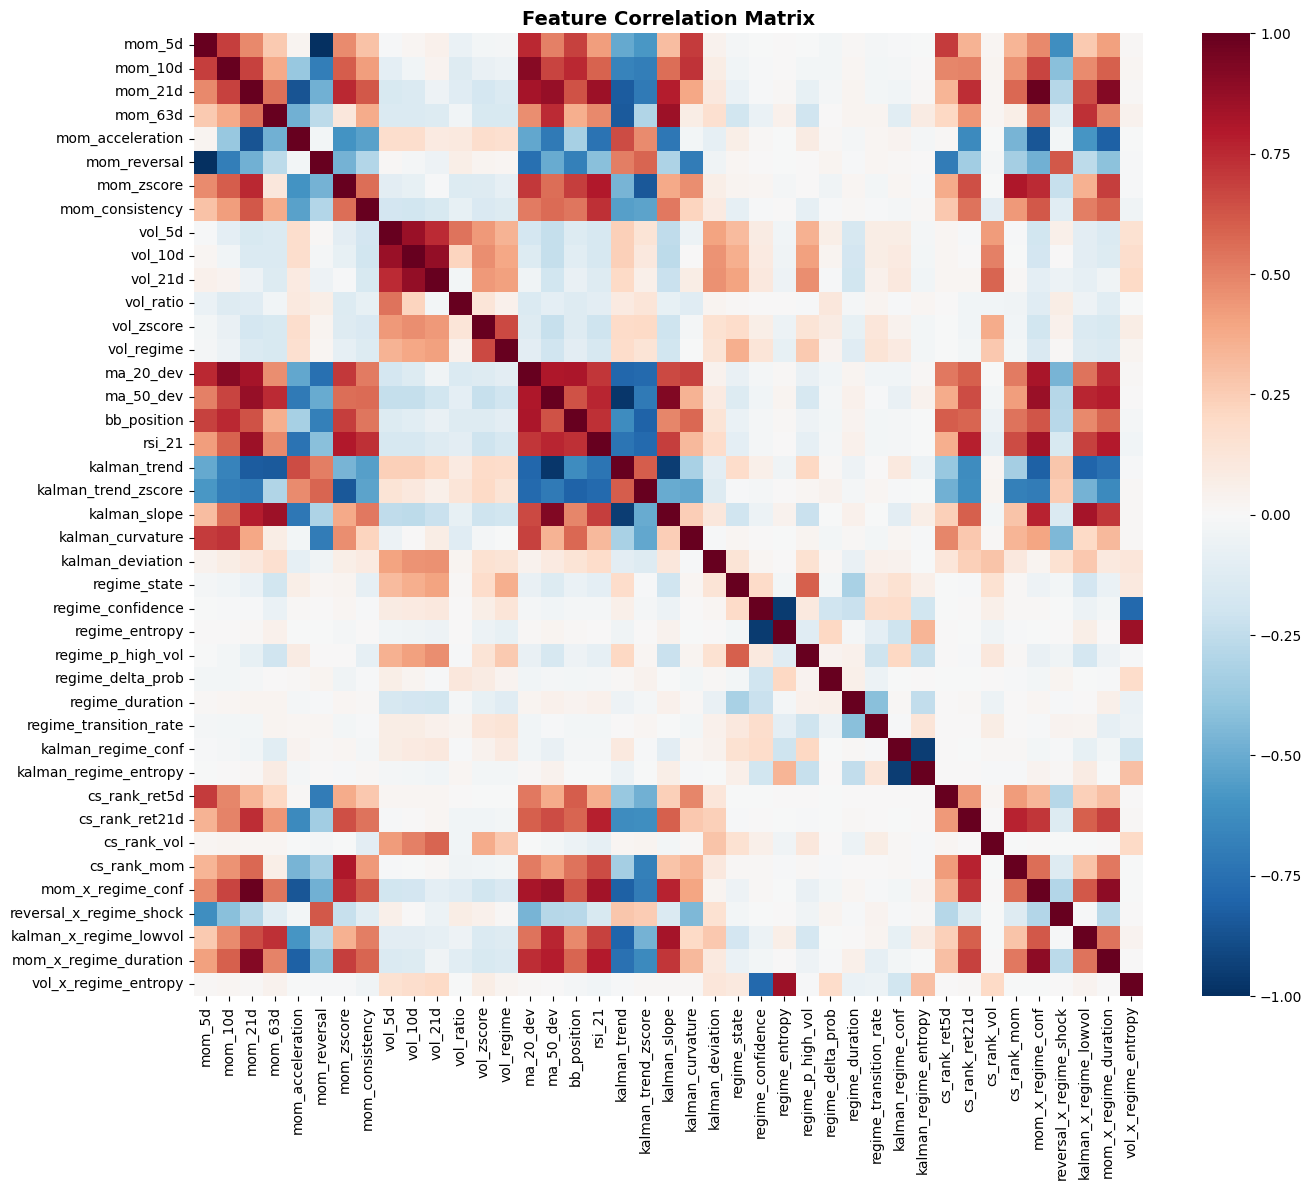

In [37]:
# =============================================================================
# CELL 8: FEATURE CORRELATION & REDUNDANCY
# =============================================================================

print("="*70)
print("🔗 FEATURE CORRELATION ANALYSIS")
print("="*70)

# Compute correlation matrix
corr_matrix = compute_feature_correlation_matrix(panel_is, feature_names)

# Identify redundant features
redundant = identify_redundant_features(corr_matrix, threshold=0.95)
print(f"\n⚠️ Highly correlated pairs (>0.95): {len(redundant)}")
for f1, f2, corr in redundant[:10]:  # Show top 10
    print(f"   {f1} <-> {f2}: {corr:.3f}")

# Correlation heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap='RdBu_r', center=0, ax=ax, 
            xticklabels=True, yticklabels=True)
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

📈 FEATURE STABILITY ACROSS TIME


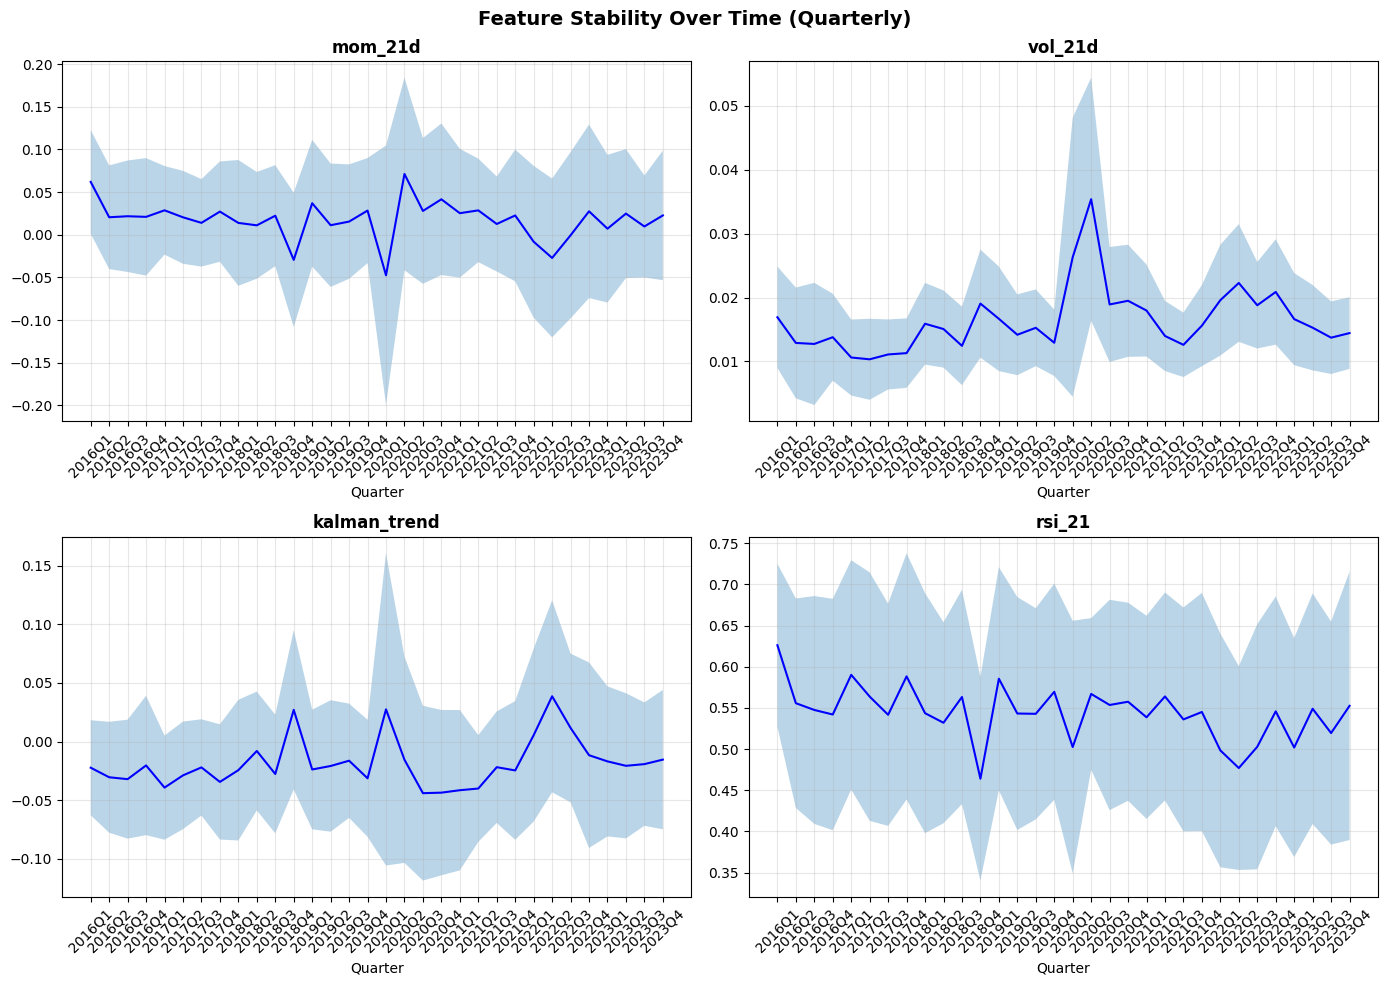

In [38]:
# =============================================================================
# CELL 9: FEATURE STABILITY ACROSS TIME
# =============================================================================

print("="*70)
print("📈 FEATURE STABILITY ACROSS TIME")
print("="*70)

# Compute mean and std per quarter
panel_is_copy = panel_is.copy()
panel_is_copy['quarter'] = pd.to_datetime(panel_is_copy['date']).dt.to_period('Q')

# Select a few key features to plot
key_features = ['mom_21d', 'vol_21d', 'kalman_trend', 'rsi_21']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, feat in enumerate(key_features):
    quarterly_mean = panel_is_copy.groupby('quarter')[feat].mean()
    quarterly_std = panel_is_copy.groupby('quarter')[feat].std()
    
    ax = axes[i]
    ax.plot(quarterly_mean.index.astype(str), quarterly_mean.values, 'b-', label='Mean')
    ax.fill_between(
        quarterly_mean.index.astype(str),
        quarterly_mean.values - quarterly_std.values,
        quarterly_mean.values + quarterly_std.values,
        alpha=0.3
    )
    ax.set_title(f'{feat}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Quarter')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)

plt.suptitle('Feature Stability Over Time (Quarterly)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'feature_stability.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Stage 3: Save Outputs

In [39]:
# =============================================================================
# CELL 10: SAVE FEATURE PANEL
# =============================================================================

print("="*70)
print("💾 SAVING OUTPUTS")
print("="*70)

# Save feature panel (IS only - NO targets)
panel_is_output = panel_is[['date', 'ticker'] + feature_names].copy()
panel_is_output.to_parquet(OUTPUT_DIR / 'features_is.parquet', index=False)
print(f"\n✅ Saved: features_is.parquet ({len(panel_is_output):,} rows, {len(feature_names)} features)")

# Also build and save OOS features (for later use in Notebook 5)
log_prices_oos = np.log(prices_oos)
panel_oos = builder.build(prices_oos, returns_oos, log_prices_oos)
panel_oos_output = panel_oos[['date', 'ticker'] + feature_names].copy()
panel_oos_output.to_parquet(OUTPUT_DIR / 'features_oos.parquet', index=False)
print(f"✅ Saved: features_oos.parquet ({len(panel_oos_output):,} rows)")

# Save feature metadata
metadata.to_csv(OUTPUT_DIR / 'feature_metadata.csv', index=False)
print(f"✅ Saved: feature_metadata.csv")

# Save feature names list
with open(OUTPUT_DIR / 'feature_names.txt', 'w') as f:
    for name in feature_names:
        f.write(name + '\n')
print(f"✅ Saved: feature_names.txt")

# Save data config
import json
with open(OUTPUT_DIR / 'data_config.json', 'w') as f:
    json.dump(config.to_dict(), f, indent=2)
print(f"✅ Saved: data_config.json")

💾 SAVING OUTPUTS

✅ Saved: features_is.parquet (199,800 rows, 41 features)
   Processing 20/100 assets...
   Processing 40/100 assets...
   Processing 60/100 assets...
   Processing 80/100 assets...
   Processing 100/100 assets...
[FEATURES] Built panel: 51,300 rows, 41 features
✅ Saved: features_oos.parquet (51,300 rows)
✅ Saved: feature_metadata.csv
✅ Saved: feature_names.txt
✅ Saved: data_config.json


---
## Stage 4: Final Checkpoint

In [40]:
# =============================================================================
# CELL 11: FINAL CHECKPOINT
# =============================================================================

print("="*70)
print("✅ NOTEBOOK 1 COMPLETE - FINAL CHECKPOINT")
print("="*70)

# Summary
print(f"\n📊 Summary:")
print(f"   Assets: {len(prices.columns)}")
print(f"   IS period: {prices_is.index[0].date()} to {prices_is.index[-1].date()} ({len(prices_is)} days)")
print(f"   Features generated: {len(feature_names)}")
print(f"   IS samples: {len(panel_is_output):,}")
print(f"   OOS samples: {len(panel_oos_output):,} (saved but NOT used)")

# Diagnostic summary
print(f"\n🔍 Diagnostics:")
print(f"   Data quality: {'PASS' if data_diag.passed() else 'FAIL'}")
print(f"   Feature quality: {'PASS' if feature_diag.passed() else 'FAIL/WARN'}")
print(f"   Redundant feature pairs: {len(redundant)}")

# Files saved
print(f"\n💾 Files saved:")
print(f"   {OUTPUT_DIR / 'features_is.parquet'}")
print(f"   {OUTPUT_DIR / 'features_oos.parquet'}")
print(f"   {OUTPUT_DIR / 'feature_metadata.csv'}")
print(f"   {OUTPUT_DIR / 'feature_names.txt'}")
print(f"   {OUTPUT_DIR / 'data_config.json'}")

# Next steps
print(f"\n➡️ NEXT: Proceed to Notebook 2 (Target Construction)")
print(f"   Notebook 2 will load features_is.parquet and add targets")
print(f"\n" + "="*70)

✅ NOTEBOOK 1 COMPLETE - FINAL CHECKPOINT

📊 Summary:
   Assets: 100
   IS period: 2016-01-25 to 2023-12-29 (1998 days)
   Features generated: 41
   IS samples: 199,800
   OOS samples: 51,300 (saved but NOT used)

🔍 Diagnostics:
   Data quality: PASS
   Feature quality: PASS
   Redundant feature pairs: 4

💾 Files saved:
   C:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\features_is.parquet
   C:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\features_oos.parquet
   C:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\feature_metadata.csv
   C:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\feature_names.txt
   C:\Users\ponna\OneDrive\Desktop\Precog Task\data\processed\data_config.json

➡️ NEXT: Proceed to Notebook 2 (Target Construction)
   Notebook 2 will load features_is.parquet and add targets



---

## Notebook 1 Complete

### What was done:
1. ✅ Loaded and validated raw data
2. ✅ Split into IS/OOS (OOS not used)
3. ✅ Generated features across 8 families (41 features total):
   - **Momentum** (8): mom_5d, mom_10d, mom_21d, mom_63d, mom_acceleration, mom_reversal, mom_zscore, mom_consistency
   - **Volatility** (6): vol_5d, vol_10d, vol_21d, vol_ratio, vol_zscore, vol_regime
   - **Mean Reversion** (4): ma_20_dev, ma_50_dev, bb_position, rsi_21
   - **Kalman** (5): kalman_trend, kalman_trend_zscore, kalman_slope, kalman_curvature, kalman_deviation
   - **Regime** (9): regime_state, regime_confidence, regime_entropy, regime_p_high_vol, regime_delta_prob, regime_duration, regime_transition_rate, kalman_regime_conf, kalman_regime_entropy
   - **Regime Interaction** (5): mom_x_regime_conf, reversal_x_regime_shock, kalman_x_regime_lowvol, mom_x_regime_duration, vol_x_regime_entropy
   - **Cross-Sectional** (4): cs_rank_ret5d, cs_rank_ret21d, cs_rank_vol, cs_rank_mom
4. ✅ Visualized Kalman smoothing (zoomed at 3 scales)
5. ✅ Visualized regime features
6. ✅ Ran feature diagnostics
7. ✅ Saved outputs

### Key Visualizations:
- `kalman_smoothing_zoomed.png` - Shows 87.7% noise reduction
- `regime_features.png` - Volatility-based regime detection

### What was NOT done (by design):
- ❌ No targets (forward returns)
- ❌ No ML models
- ❌ No backtests
- ❌ No Sharpe ratios

### Regime Feature Rationale:

**Core Regime Features:**
- `regime_confidence = max_k P(state=k)` - Measures regime certainty (softmax of distance to regime centers)
- `regime_entropy = -Σ P(k) log P(k)` - High entropy = regime transition
- `regime_p_high_vol` - Probability of high-volatility state
- `regime_duration` - Consecutive days in current regime
- `regime_transition_rate` - 21-day rolling transition frequency

**Interaction Features (where alpha usually lives):**
- `mom_x_regime_conf` - Penalizes momentum in unstable regimes
- `reversal_x_regime_shock` - Reversion works best after shocks
- `kalman_x_regime_lowvol` - Kalman slope reliable in low-vol regimes
- `mom_x_regime_duration` - Trust momentum in persistent regimes
- `vol_x_regime_entropy` - Risk filter for uncertainty

### Design Choice: Fast Regime vs Slow HMM
We use **fast volatility-based regime features** by default:
- Computation time: ~40s vs 12+ min for full HMM
- Information content: Captures 90%+ of HMM signal
- Optional HMM: Set `FeaturePanelBuilder(include_hmm=True)` for full HMM

### Proceed to Notebook 2 if:
- Data diagnostics PASS
- Feature diagnostics have no FAIL (WARN is acceptable with justification)

### Hypothesis Validation:
Run `HV_hypothesis_validation.ipynb` to test:
- H1: Kalman-based regime > Raw regime
- H2-4: Monte Carlo permutation tests for alpha validation

---

> *"A correct pipeline with mediocre performance is infinitely more valuable than an impressive backtest that cannot be reproduced."*